# Genetic Algorithms vs. Sumulated Annealing 
### Regression Approximation

By Max Wiesner

In [1]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
from curveFitting import one_dimensional_curve_fitting_test
from matplotlib import pyplot as plt
from IPython.display import display, HTML
import pprint
import pandas as pd
import math

tests = [
    [lambda x: 0.2*math.exp(x/4.0) -  math.sin(2*x), (-10.0, 10.0), 25],
    [lambda x: math.sin(2*x) - math.cos(3*x-1) + 2*math.sin(x/2+1.0), (-15.0, 15.0), 60],
    [lambda x: math.exp(math.sin(2*x)) - math.exp(math.cos(3*x)), (-15.0, 15.0), 60],
    [lambda x: 0.05*x**2 - 0.5*x + 5.0 * math.sin(3*x) , (-15.0, 15.0), 60],
    [lambda x: 0.05*x**2 - 0.5*math.sqrt(x) + 5.0 * math.sin(3*x) , (0.0, 15.0), 30]
]

each_test = 3
i_std = 4 # 100
p_std = 1  # 10
n_std = 10 # 100
GA_criteria = np.array([[i_std*10, p_std*4, n_std*1], 
                        [i_std*5, p_std*8, n_std*1], 
                        [i_std*2.5, p_std*16, n_std*1]]).astype(int)
SA_criteria = np.array([[i_std*100, p_std*4, n_std*1],
                        [i_std*50, p_std*8, n_std*1],
                        [i_std*25, p_std*16, n_std*1]]).astype(int)

test_instances = [{'results': [[-float('inf')]*5 for i in range(3)],
                   'all': [[0]*5 for i in range(3)],
                   'conditions': criteria} for criteria in [GA_criteria, SA_criteria]]

with tqdm(total = each_test*len(GA_criteria)*len(test_instances)*len(tests)) as pbar:
    for iteration in range(each_test):
        for curr_algorithm_index in range(len(test_instances)):
            for curr_condition_index in range(len(test_instances[curr_algorithm_index]['conditions'])):
                for curr_test_index in range(len(tests)):
                    all_data_results = one_dimensional_curve_fitting_test(tests[curr_test_index][0], 
                        tests[curr_test_index][1], 
                        tests[curr_test_index][2], 
                        test_instances[curr_algorithm_index]['conditions'][curr_condition_index][0],
                        test_instances[curr_algorithm_index]['conditions'][curr_condition_index][1], 
                        test_instances[curr_algorithm_index]['conditions'][curr_condition_index][2],
                        'ga' if curr_algorithm_index == 0 else 'sa')
                    
                    if all_data_results[1] > test_instances[curr_algorithm_index]['results'][curr_condition_index][curr_test_index]:
                        test_instances[curr_algorithm_index]['results'][curr_condition_index][curr_test_index] = all_data_results[1]
                        test_instances[curr_algorithm_index]['all'][curr_condition_index][curr_test_index] = all_data_results
                    pbar.update(1)

100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


In [53]:
names = ['Genetic Algorithm', 'Simulated Annealing Algorithm']
plot_printout_indexs = []

css = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(css))

title_specs = {
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '18px')
    ]
}


def highlight_last_max(data, colormax='antiquewhite', colormaxlast='lightgreen'):

    colormax_attr = f'background-color: {colormax}'
    colormaxlast_attr = f'background-color: {colormaxlast}'
    max_value = data.max()
    is_max = [colormax_attr if v == max_value else '' for v in data]
    is_max[len(data) - list(reversed(data)).index(max_value) -  1] = colormaxlast_attr
    return is_max


def highlight_max_save(data, colormax='antiquewhite', colormaxlast='lightgreen', index = 0):
    
    is_max = [1 if v == data.max() else 0 for v in data]
    max_index_x = is_max.index(max(is_max))
    max_contendors = [test_instances[index]['results'][i][max_index_x] for i in range(3)]
    max_index_y = max_contendors.index(max(max_contendors))
    plot_printout_indexs.append([index, max_index_x, max_index_y])
    
    return highlight_last_max(data, colormax, colormaxlast)
    
    
def create_data_frames():
    dfs = [None]*2
     
    for ind in range(len(names)):
        df = pd.DataFrame(np.array( [[test_instances[ind]['results'][i][j] for j in range(5)] for i in range(3)]), index = [f'{crit[0]}, {crit[1]}' for crit in GA_criteria], 
                                   columns = [f'Function {i}' for i in range(1, 6)])
        df.style.set_table_attributes("style='display:inline'").set_caption(f'{names[ind]} - Regression Estimation')
        df.loc['Fitness Avg by Function']= df.mean(numeric_only=True, axis=0)
        df.loc[:,'Fitness Avg by Criteria'] = df.mean(numeric_only=True, axis=1)
        pd.options.display.float_format = '{:,.3f}'.format        
        df = df.rename_axis('Criteria: Num of Iterations, Population Size')
        
        df['Run Time Avg by Criteria'] = [np.mean([test_instances[ind]['all'][i][j][3] for j in range(5)]) for i in range(3)] + [None]
        df.loc['Run Time Avg by Function'] = [np.mean([test_instances[ind]['all'][i][j][3] for i in range(3)]) for j in range(5)] + \
            [None, np.mean([np.mean([test_instances[ind]['all'][i][j][3] for i in range(3)]) for j in range(5)])]
        
        df = df.style.apply(highlight_last_max, subset = pd.IndexSlice[[f'{crit[0]}, {crit[1]}' for crit in GA_criteria], [f'Function {i}' for i in range(1, 6)]], axis = 0) \
            .set_table_attributes("style='display:inline'") \
            .set_caption(f'{names[ind]} - Regression Estimation') \
            .set_table_styles([title_specs]) \
            .apply(highlight_max_save, subset = pd.IndexSlice["Fitness Avg by Function", \
                                            [f'Function {i}' for i in range(1, 6)]], axis = 1, colormaxlast = 'lightblue', index = ind) \
            .apply(highlight_max_save, subset = pd.IndexSlice["Run Time Avg by Function", \
                                            [f'Function {i}' for i in range(1, 6)]], axis = 1, colormaxlast = 'lightblue', index = ind) \
            .apply(highlight_last_max, subset = pd.IndexSlice[ [f'{crit[0]}, {crit[1]}' for crit in GA_criteria], \
                                            ['Fitness Avg by Criteria', 'Run Time Avg by Criteria']], axis = 0, colormaxlast = 'lightblue') \
            .apply(highlight_last_max, subset = pd.IndexSlice["Fitness Avg by Function", ['Fitness Avg by Criteria']], axis = 0, colormaxlast = '#ffcccb')  \
            .apply(highlight_last_max, subset = pd.IndexSlice["Run Time Avg by Function", ['Run Time Avg by Criteria']], axis = 0, colormaxlast = '#ffcccb')  
        dfs[ind] = df        
    return dfs


def print_plots(plot, message = 0):
    message = "Best Performing Function in Highest Average Fitness Column" if message == 0 else "Best Performing Funciton in Fastest Average Runtime Column"
    criteria = GA_criteria if plot[0] == 0 else SA_criteria
    population_name = "Population" if plot[0] == 0 else "Neighborhood Size"
    data = test_instances[plot[0]]['all'][plot[2]][plot[1]][4].regression_training_data
    test_points = test_instances[plot[0]]['all'][plot[2]][plot[1]][4].test_points
    best_expr = test_instances[plot[0]]["all"][plot[2]][plot[1]][0]
    stats = test_instances[plot[0]]["all"][plot[2]][plot[1]][2]
    print(f'\n\n\n{names[plot[0]]} : \n   [{message}] : Function {plot[1] + 1}')
    print(f'   Iterations = {criteria[plot[2]][0]}, {population_name} = {criteria[plot[2]][1]}')
    print(f'   Function: {best_expr}')
    print(f'   Fitness: {test_instances[plot[0]]["all"][plot[2]][plot[1]][1]}')
    print(f'   Runtime: {test_instances[plot[0]]["all"][plot[2]][plot[1]][3]}\n')

    plt.figure(1)
    x_values = [x_value for ([x_value], _) in data]
    plt.plot(x_values, [y for (_,y) in data],'x')
    test_xvalues = sorted([x for [x] in test_points])
    result = [best_expr.eval({'x':x_value}) for x_value in test_xvalues]

    gTruth = [tests[plot[1]][0](x_value) for x_value in test_xvalues ]
    plt.plot(test_xvalues, result, 'r-',label='ga_fit')
    plt.plot(test_xvalues, gTruth, 'g-', label='ground-truth')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.figure(2)
    plt.plot(range(len(stats)), [st for st in stats], 'b-')
    plt.xlabel('Iters')
    plt.ylabel('Max Fitness')
    plt.plot(range(len(stats)), [(st if st > -100 else -100) for st in stats], 'r--')
    plt.show()

[]




,Function 1,Function 2,Function 3,Function 4,Function 5,Fitness Avg by Criteria,Run Time Avg by Criteria
"Criteria: Num of Iterations, Population Size",,,,,,,
"40, 4",-15.0463,-124.081,-42.702,-1805.17,-284.418,-454.283,0.149592
"20, 8",-22.6293,-103.587,-38.2781,-2113.38,-410.469,-537.668,0.15464
"10, 16",-12.7874,-118.899,-54.702,-1833.59,-332.323,-470.46,0.0946285
Fitness Avg by Function,-16.821,-115.522,-45.2274,-1917.38,-342.403,-487.471,nan
Run Time Avg by Function,0.0851777,0.124831,0.183847,0.164025,0.106887,nan,0.132953





Genetic Algorithm : 
   [Best Performing Function in Highest Average Fitness Column] : Function 1
   Iterations = 10, Population = 16
   Function: cos(cos(x))
   Fitness: -12.787397854464947
   Runtime: 0.05002617835998535



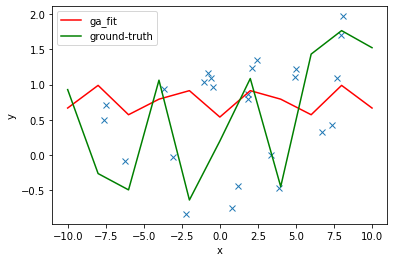

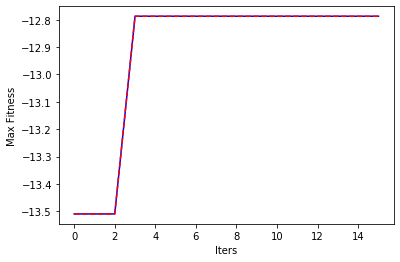




Genetic Algorithm : 
   [Best Performing Funciton in Fastest Average Runtime Column] : Function 3
   Iterations = 20, Population = 8
   Function: sin((x * 2.0))
   Fitness: -38.27807649191646
   Runtime: 0.18378925323486328



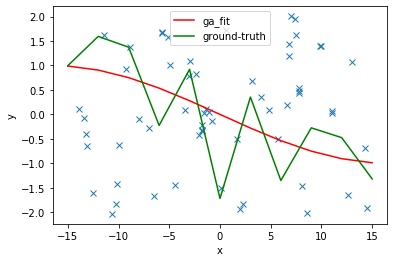

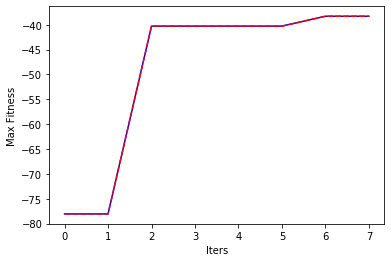

,Function 1,Function 2,Function 3,Function 4,Function 5,Fitness Avg by Criteria,Run Time Avg by Criteria
"Criteria: Num of Iterations, Population Size",,,,,,,
"40, 4",-19.853,-253.261,-97.2399,-2323.83,-467.69,-632.374,0.880086
"20, 8",-17.0712,-177.247,-101.924,-2467.53,-585.429,-669.841,0.567732
"10, 16",-17.2832,-138.248,-76.7438,-2600.35,-497.929,-666.111,0.720822
Fitness Avg by Function,-18.0692,-189.585,-91.9693,-2463.9,-517.016,-656.109,nan
Run Time Avg by Function,0.460937,0.909158,0.862609,0.849369,0.532328,nan,0.72288





Simulated Annealing Algorithm : 
   [Best Performing Function in Highest Average Fitness Column] : Function 1
   Iterations = 200, Neighborhood Size = 8
   Function: (-1.0 * -0.5)
   Fitness: -17.071226728586165
   Runtime: 0.4299921989440918



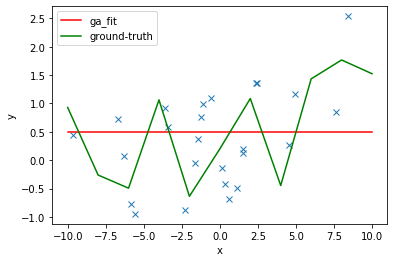

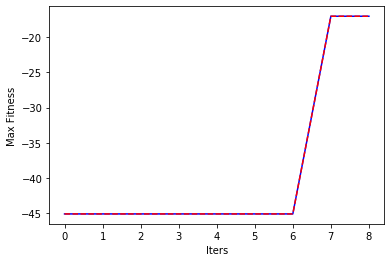




Simulated Annealing Algorithm : 
   [Best Performing Funciton in Fastest Average Runtime Column] : Function 2
   Iterations = 100, Neighborhood Size = 16
   Function: sin(1.0)
   Fitness: -138.24791827044183
   Runtime: 1.097238302230835



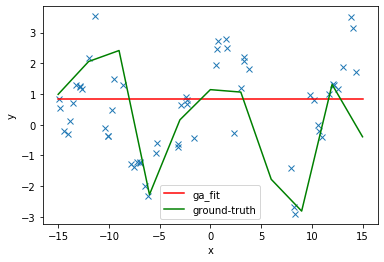

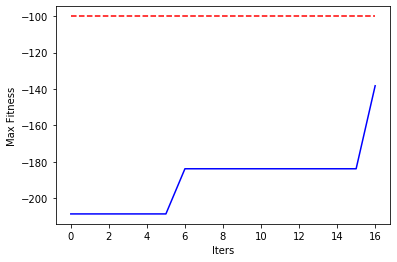

In [54]:
print(plot_printout_indexs)
dfs = create_data_frames()
print('\n')
display(dfs[0])
print_plots(plot_printout_indexs[0], 0)
print_plots(plot_printout_indexs[1], 1)
print('\n')
display(dfs[1])
print_plots(plot_printout_indexs[2], 0)
print_plots(plot_printout_indexs[3], 1)

Write a brief analysis of your results. Some questions to answer:
- Which problem ran the fastest? Why do you think this is the case?
- Which problem ended with the highest fitness? Why do you think this is the case?
- How similar were the running times across the 5 repetitions?
- How similar were the final fitness scores across the 5 repetitions?
- Was there anything else interesting in your results?

`Your answer here.`

## Describe Your Implementation and Reflect

Some questions to answer in your write-up:
- What was your strategy to solve this problem?
- How did you structure your `GASolver` class?
- What other files or methods did you change?
- What was the most difficult part of the project?
- What was something surprising you found?

Please provide some elaboration with your answers. When describing your implementation, remember that we have not watched you solve this problem so you will need to give more details than you think is necessary.

`Your answer here.`

## Going Above and Beyond

Describe the extra changes you implemented. Give some details, perhaps a short paragraph for each major change.

`Your answer here.`

Describe the analysis you did and provide your results in the form of a figure or a table.

`Your answer here.`

Reflect on your work for this section. What was interesting, or what did you learn? A short paragraph here is fine.

`Your answer here.`